In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/ LoRaWANdataset/machine_2_with_Noise_sensor1.csv'
IMP_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg','converted', 'target']
X_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg','converted', 'ZRMSmg']
TAR_COL = 'target'

In [ ]:
df = pd.read_csv(DATASET_PATH)[IMP_COL]
df.columns
# df.sort_values(by='converted', inplace = True)
df = df.drop(['converted'], axis=1)

<ipython-input-6-2d366cf5db0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target -= 1
<ipython-input-6-2d366cf5db0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target *= 40


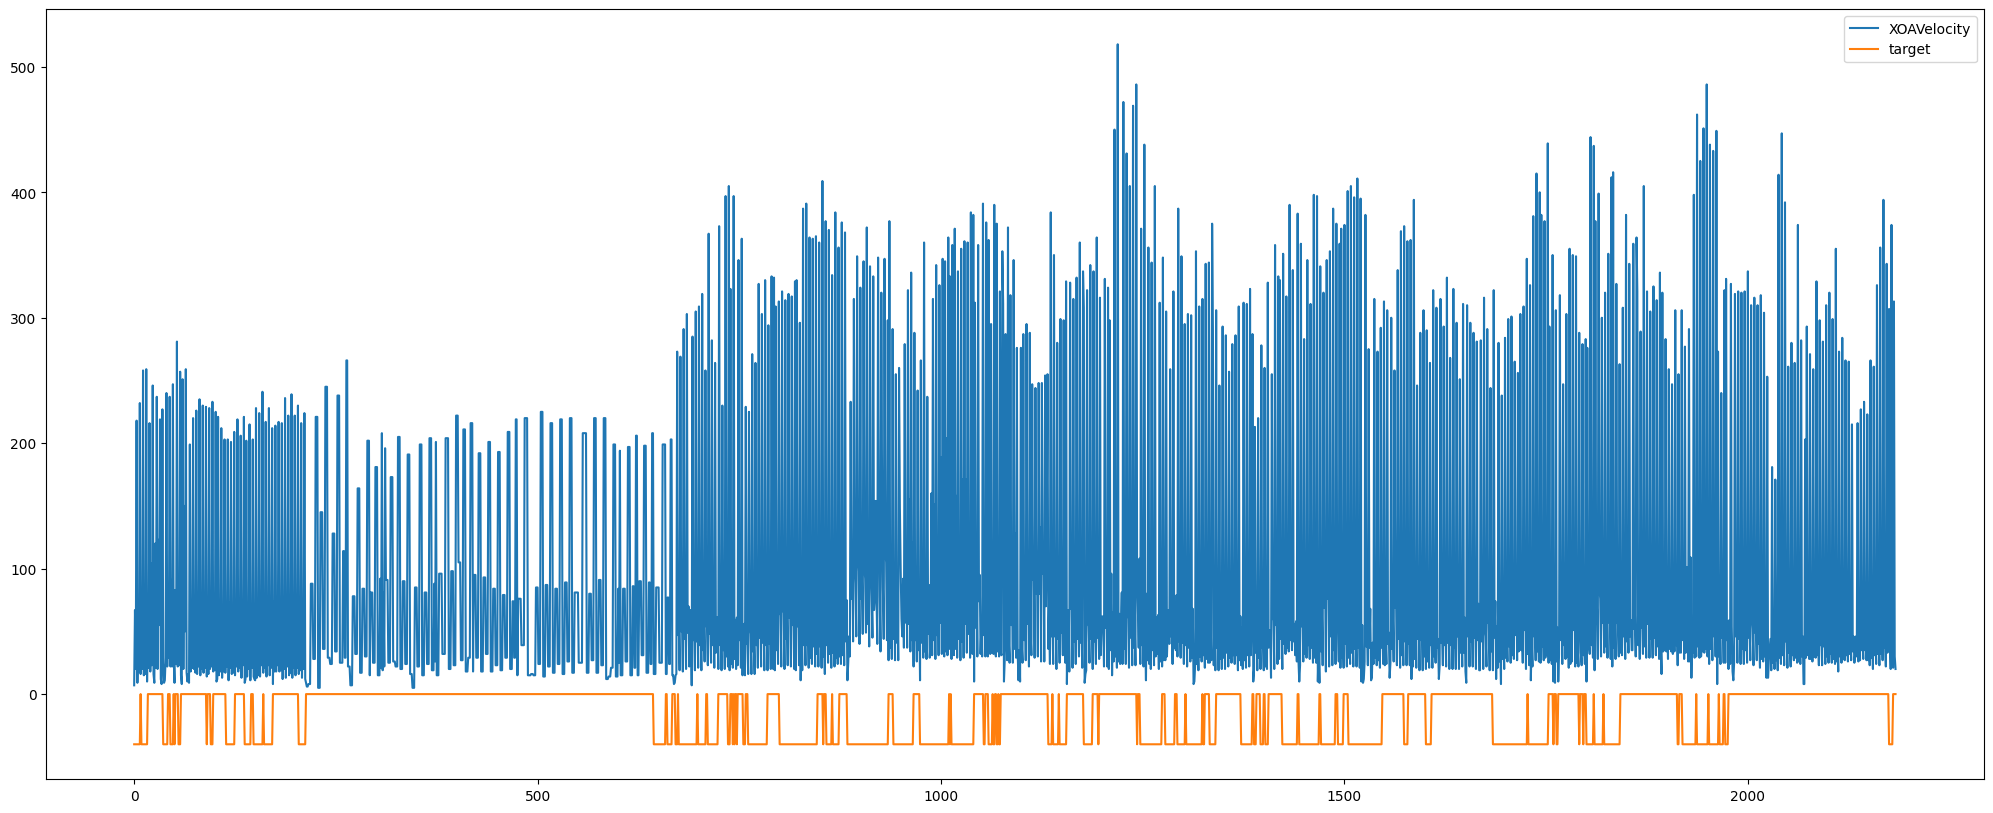

In [ ]:
df1 = df.drop(['XCrestFactor','ZPeakmg','ZRMSmg'], axis=1)
df1 = df[['XOAVelocity','target']]
df1.target -= 1
df1.target *= 40
plt.figure(figsize=(25,10)) 
plt.plot(df1)
plt.legend(df1.columns)
plt.show()

In [ ]:
def generateFrames(size = 6,overlap = True):
  # generate overlapping frames
  #list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 1 if overlap else size) if i < len(df) - size]
  #print(list_of_dfs)
  list_of_dfs = []

  # Loop over the range of indices in the original dataframe
  for i in range(0, len(df), 1 if overlap else size):
    # Check if the current index is within range of the dataframe
    if i < len(df) - size:
        # Slice the dataframe to extract a chunk of the specified size
        chunk = df.loc[i:i+size-1,:]
        # Add the chunk to the list of resulting dataframes
        list_of_dfs.append(chunk)
  
  data = []
  labels = []

  for d in list_of_dfs:
    if(len(d)==size):
      values = d[['XOAVelocity']].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      data.append(values)

      # label as 1 if not noisy false otherwise
      labels.append(d['target'].sum() < 2)

  labels = np.asarray(labels, dtype=bool) 
  data = np.array(data)

  return (data,labels)

def splitTrainTest(ratio, data, labels):
  
  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,labels_train, x_test,labels_test)

In [ ]:
frames, labels = generateFrames(12)
train_data, train_labels, test_data, test_labels = splitTrainTest(0.7, frames, labels)

(len(train_data),len(test_data))

(1520, 652)

In [ ]:
model = tf.keras.Sequential([
    # todo:  no longer multivarite
    tf.keras.layers.Dense(24, activation='softmax'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=25)

Epoch 1/25
48/48 [==============================] - 6s 9ms/step - loss: 0.6644 - accuracy: 0.7803
Epoch 2/25
48/48 [==============================] - 0s 9ms/step - loss: 0.6055 - accuracy: 0.7803
Epoch 3/25
48/48 [==============================] - 0s 6ms/step - loss: 0.5501 - accuracy: 0.7803
Epoch 4/25
48/48 [==============================] - 0s 5ms/step - loss: 0.5284 - accuracy: 0.7803
Epoch 5/25
48/48 [==============================] - 0s 5ms/step - loss: 0.5255 - accuracy: 0.7803
Epoch 6/25
48/48 [==============================] - 0s 6ms/step - loss: 0.5254 - accuracy: 0.7803
Epoch 7/25
48/48 [==============================] - 0s 4ms/step - loss: 0.5251 - accuracy: 0.7803
Epoch 8/25
48/48 [==============================] - 0s 6ms/step - loss: 0.5249 - accuracy: 0.7803
Epoch 9/25
48/48 [==============================] - 0s 5ms/step - loss: 0.5245 - accuracy: 0.7803
Epoch 10/25
48/48 [==============================] - 0s 6ms/step - loss: 0.5248 - accuracy: 0.7803
Epoch 11/25
48/48 [

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

21/21 - 0s - loss: 0.5437 - accuracy: 0.7699 - 327ms/epoch - 16ms/step

Test accuracy: 0.7699386477470398


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

class AutoEnc(Model):
  def __init__(self):
    super(AutoEnc, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEnc()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(train_data, train_data, 
          epochs=20, 
          validation_data=(test_data, test_data),
         )

Epoch 1/20
48/48 [==============================] - 3s 13ms/step - loss: 0.4073 - val_loss: 0.4157
Epoch 2/20
48/48 [==============================] - 0s 8ms/step - loss: 0.3794 - val_loss: 0.3584
Epoch 3/20
48/48 [==============================] - 0s 7ms/step - loss: 0.3418 - val_loss: 0.3083
Epoch 4/20
48/48 [==============================] - 0s 8ms/step - loss: 0.2950 - val_loss: 0.2378
Epoch 5/20
48/48 [==============================] - 0s 7ms/step - loss: 0.2651 - val_loss: 0.2156
Epoch 6/20
48/48 [==============================] - 0s 7ms/step - loss: 0.2525 - val_loss: 0.2045
Epoch 7/20
48/48 [==============================] - 0s 6ms/step - loss: 0.2447 - val_loss: 0.1964
Epoch 8/20
48/48 [==============================] - 0s 6ms/step - loss: 0.2387 - val_loss: 0.1904
Epoch 9/20
48/48 [==============================] - 0s 5ms/step - loss: 0.2337 - val_loss: 0.1840
Epoch 10/20
48/48 [==============================] - 0s 6ms/step - loss: 0.2294 - val_loss: 0.1783
Epoch 11/20
48/48 

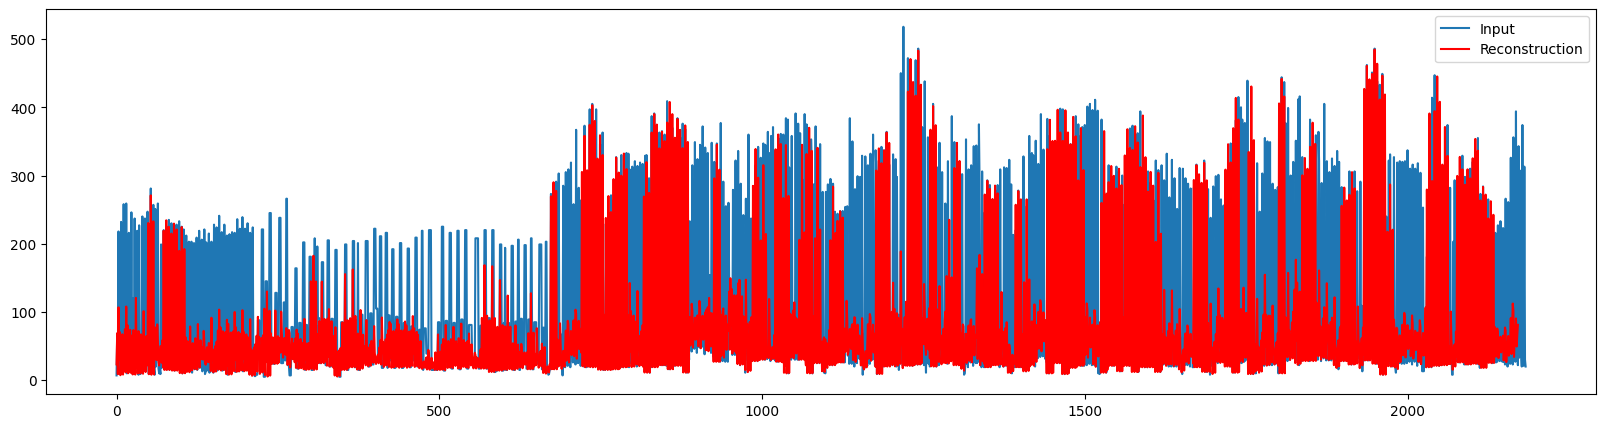

In [ ]:
def plotUsingAutoEncoder(model):
  size = 12
  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 12) if i < len(df) - 12]
    
  denoised = []

  for d in list_of_dfs:
    if(len(d) == size):
      values = d[['XOAVelocity']].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      encoded_data = model.encoder( np.array([values])).numpy()
      [values] = model.decoder(encoded_data).numpy()
      values = (np.array(values) * (max_val - min_val).numpy())   + min_val.numpy()
      denoised = np.concatenate((np.array(denoised) , np.array(values)))

  denoised = np.array(denoised)
  noise = df[['XOAVelocity']].values.flatten()

  plt.figure(figsize=(20,5)) 
  plt.plot(noise)
  plt.plot(denoised, color="red")
  plt.legend(labels=["Input", "Reconstruction" ])
  plt.show()

plotUsingAutoEncoder(autoencoder)

In [ ]:
class Discriminator(Model):
   def __init__(self):
    super(Discriminator, self).__init__()
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(12,) ),
        tf.keras.layers.Dense(12, activation='softmax'),
        tf.keras.layers.Dense(6, activation='softmax'),
        tf.keras.layers.Dense(3, activation='softmax'),
        tf.keras.layers.Dense(1)
    ])
  
   def call(self, x):
    return self.model(x)
 

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

generator = Generator()
discriminator = Discriminator()

generator.compile(optimizer='adam', loss='mae')
discriminator.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

# generator.fit(train_data, train_data, epochs = 20, validation_data=(test_data, test_data))
discriminator.fit(train_data, train_labels, epochs=10)

# real --> Without noise
# fake -> With noise

Epoch 1/10
48/48 [==============================] - 2s 4ms/step - loss: 0.6577 - accuracy: 0.7803
Epoch 2/10
48/48 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.7803
Epoch 3/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.7803
Epoch 4/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5666 - accuracy: 0.7803
Epoch 5/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5522 - accuracy: 0.7803
Epoch 6/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5427 - accuracy: 0.7803
Epoch 7/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5366 - accuracy: 0.7803
Epoch 8/10
48/48 [==============================] - 0s 4ms/step - loss: 0.5327 - accuracy: 0.7803
Epoch 9/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5302 - accuracy: 0.7803
Epoch 10/10
48/48 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.7803


In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

21/21 - 0s - loss: 0.5437 - accuracy: 0.7699 - 55ms/epoch - 3ms/step

Test accuracy: 0.7699386477470398


In [ ]:
max_epochs = 20
learning_rate_G = 0.001

generator_optimizer = tf.optimizers.Adam(learning_rate_G )

Epoch 0 Starting
Epoch 0 DONE


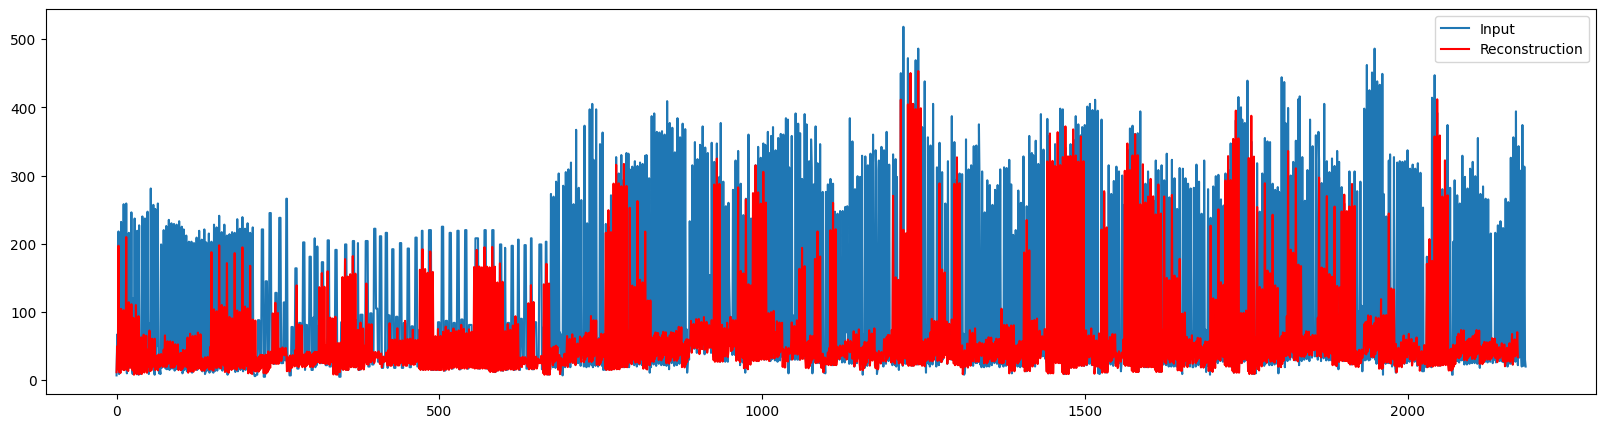

Epoch 1 Starting
Epoch 1 DONE


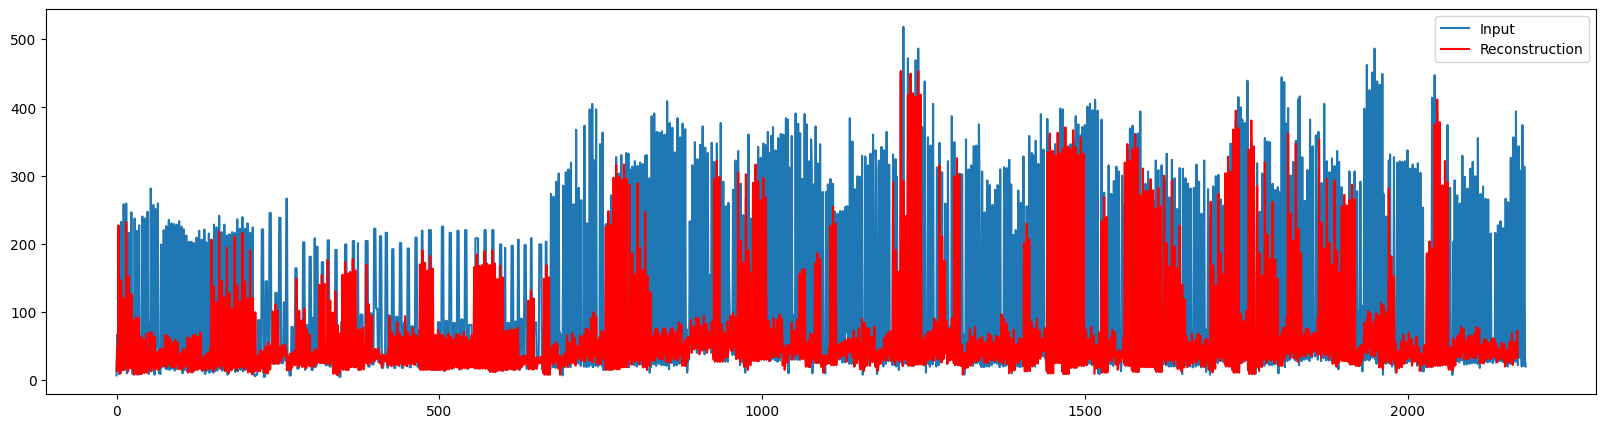

Epoch 2 Starting
Epoch 2 DONE


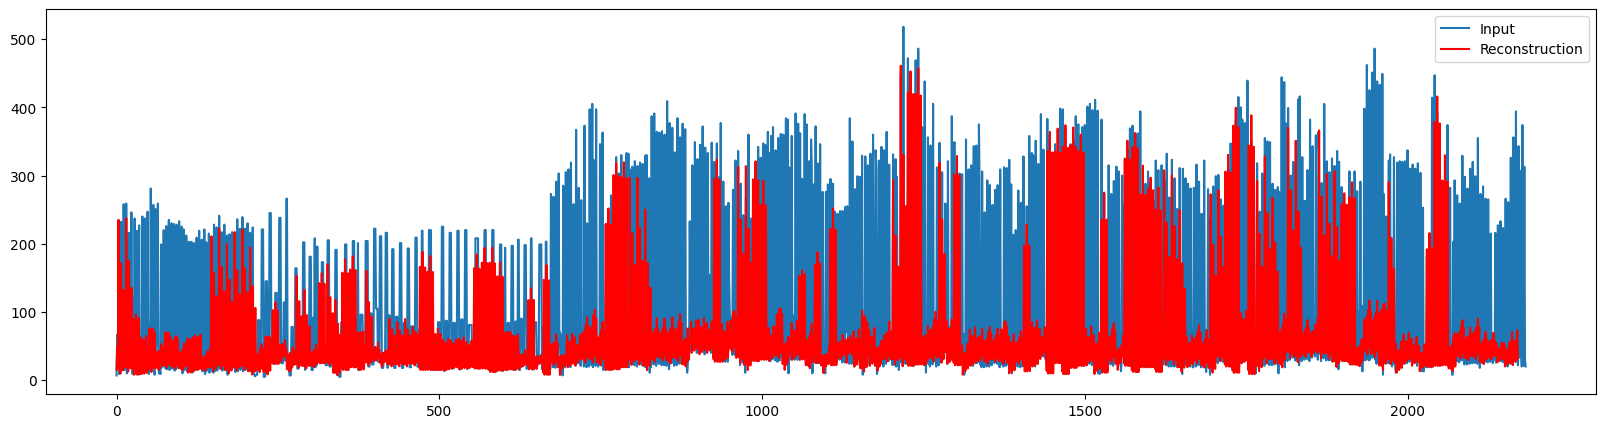

Epoch 3 Starting


KeyboardInterrupt: ignored

In [ ]:
#print(discriminator.variables)
#global_step = tf.train.get_or_create_global_step()

step = 0
for epoch in range(max_epochs):
  print("Epoch " + str(epoch) +" Starting")

  for frame in train_data:
    #print(frame)
    with tf.GradientTape() as gen_tape:
      output = generator(np.array([frame]))
      disc_output = discriminator(np.array(output))
     
      mae = tf.keras.losses.MeanAbsoluteError() 
      gen_loss = mae(frame, output[0]) * -disc_output[0][0]

      # calculate loss
      #gen_loss = generator_loss(fake_logits)
    # print(gen_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    # print(gen_loss)
    # print(gradients_of_generator)
    # print(" ++++ ")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    # epochs = step * batch_size / float(len(train_data))
  print("Epoch " + str(epoch) +" DONE")
  plotUsingAutoEncoder(generator)

# print(generator.variables)